In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.io import loadmat
from scipy.interpolate import interp1d
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# LOAD BOTTOM SLOPES 
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/CM26_global_slope.mat')
lon0 = x['lon'][:,0]
lat = x['lat'][:,0]
gamma0 = np.transpose(x['gamma']) # eastward 
alpha0 = np.transpose(x['alpha']) # northward 
roughness = np.transpose(x['rms_rough'])
# realign so lon-grid goes from 0-360
roughness = np.concatenate((roughness[:,lon0 >= 0], roughness[:,lon0 < 0]),axis=1)
alpha0 = np.concatenate((alpha0[:,lon0 >= 0], alpha0[:,lon0 < 0]),axis=1)
gamma0 = np.concatenate((gamma0[:,lon0 >= 0], gamma0[:,lon0 < 0]),axis=1)
lon = np.concatenate((lon0[lon0 >= 0], lon0[lon0 < 0]+360))

In [3]:
# LOAD EOFS
cm26_eof_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_EOF_analysis.nc'
cmEOF = xr.open_dataset(cm26_eof_path)
# shift EOF longitudes to match with modes 
lon01 = cmEOF.lon.data
eofu1 = np.concatenate((cmEOF.EOF1u[:,:,lon01 >= 0].data, cmEOF.EOF1u[:,:,lon01 < 0].data),axis=2)
eofv1 = np.concatenate((cmEOF.EOF1v[:,:,lon01 >= 0].data, cmEOF.EOF1v[:,:,lon01 < 0].data),axis=2)
lon1 = np.concatenate((lon01[lon01 >= 0], lon01[lon01 < 0]+360))
lat1 = cmEOF.lat.data
data_coords = {'depth': cmEOF.zl.data, 'latitude': lat1, 'longitude': lon1}
EOF1u = xr.DataArray(data=eofu1, dims=['depth','latitude','longitude'], coords=data_coords) 
EOF1v = xr.DataArray(data=eofv1, dims=['depth','latitude','longitude'], coords=data_coords) 
# trim in lat to match N2 data (maybe not needed)
EOF1u_trim = EOF1u[:,4:-25,:]
EOF1v_trim = EOF1v[:,4:-25,:]
lat_trim = lat1[4:-25]
EOF_z = cmEOF.zl.data

In [29]:
# LOAD CM MKE 
cm26_BTuv_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_Barotropic_velocities.nc'
cmMKE = xr.open_dataset(cm26_BTuv_path)
lon0BT = cmMKE.xu_ocean.data
BTu = np.concatenate((cmMKE.u_BT[:,lon0BT >= 0].data, cmMKE.u_BT[:,lon0BT < 0].data),axis=1)
BTv = np.concatenate((cmMKE.v_BT[:,lon0BT >= 0].data, cmMKE.v_BT[:,lon0BT < 0].data),axis=1)
MKE0 = 0.5*(BTu**2 + BTv**2)
lonBT = np.concatenate((lon0BT[lon0BT >= 0], lon0BT[lon0BT < 0]+360))
latBT = cmMKE.yu_ocean.data
data_coords = {'latitude': latBT[::2], 'longitude': lonBT[::2]}
MKE = xr.DataArray(data=MKE0[::2,::2], dims=['latitude', 'longitude'], coords=data_coords) 

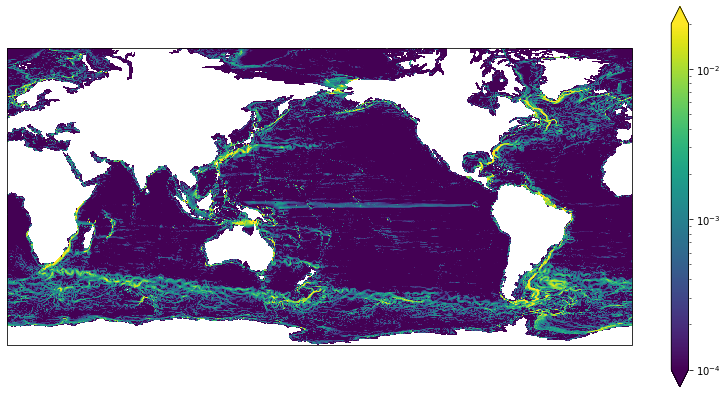

In [34]:
f, ax = plt.subplots(1,1,figsize=(14,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
MKE.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'), add_colorbar=True, norm=LogNorm(vmin=0.0001, vmax=0.02))

In [232]:
# LOAD CM UV compute MEKE 
cm26_u_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_u_1year.nc'
cm26_v_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_v_1year.nc'
cmU = xr.open_dataset(cm26_u_path)
cmV = xr.open_dataset(cm26_v_path)
lon0UV = cmU.xu_ocean.data
U = np.concatenate((cmU.u_full[:,:,:,lon0UV >= 0].data, cmU.u_full[:,:,:,lon0UV < 0].data),axis=3)
V = np.concatenate((cmV.v_full[:,:,:,lon0UV >= 0].data, cmV.v_full[:,:,:,lon0UV < 0].data),axis=3)
EKE0 = 0.5*(np.nanmean(U[:,0],axis=0)**2 + np.nanmean(V[:,0],axis=0)**2)
lonUV = np.concatenate((lon0UV[lon0UV >= 0], lon0UV[lon0UV < 0]+360))
latUV = cmV.yu_ocean.data
data_coords = {'latitude': latUV, 'longitude': lonUV}
EKE = xr.DataArray(data=EKE0, dims=['latitude', 'longitude'], coords=data_coords) 

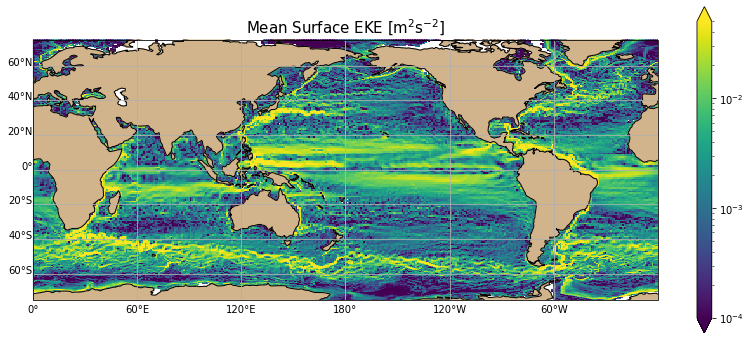

In [256]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
EKE.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'), add_colorbar=True, norm=LogNorm(vmin=0.0001, vmax=0.05))
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True); ax.set_title(r'Mean Surface EKE [m$^{2}$s$^{-2}$]',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax.set_ylim([-75,75])
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/meke.jpg', dpi=300)

In [34]:
# LOAD CMN2
cm26_n2_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_N2_gsw.nc'
cmN2 = xr.open_dataset(cm26_n2_path)
lon02 = cmN2.xu_ocean.data
N2_s = np.concatenate((cmN2.N2[:,:,lon02 >= 0].data, cmN2.N2[:,:,lon02 < 0].data),axis=2)
N2_s_z = cmN2.depth.data
lon2 = np.concatenate((lon02[lon02 >= 0], lon02[lon02 < 0]+360))
lat2 = cmN2.yu_ocean.data

In [4]:
# LOAD ARGO N2 (for now match N2 to CM2.6 grid)
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/global_1deg_N2smooth_slope.mat') # global_n2_2deg_slope.mat')
N2_lon = x['lon'][:,0]    
# N2_lon[N2_lon < 0] = 360-np.abs(N2_lon[N2_lon < 0])
N2_lat = x['lat'][:,0]   
N2 = x['N2']      
N2 = np.concatenate((N2[N2_lon < 180,:,:], N2[N2_lon > 180,:,:]),axis=0)
N2_z = -1.*x['dep'][:,0]

In [5]:
# LOAD ARGO DENSITY (BETTER EFOLDING SCALE EST)
x = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/Argo/Argo_rho_decay_dep_2018.nc')
H_topo = x['depth'].data
decay = np.nanmean(x['decay'],axis=0)/H_topo
lon_d = x['longitude'].data
lat_d = x['latitude'].data

In [6]:
# flip sign for subsequent characterization
eof1u = np.nan*np.ones(np.shape(EOF1u))
eof1v = np.nan*np.ones(np.shape(EOF1u))
for i in tqdm(range(np.shape(EOF1u)[1])):
    for j in range(np.shape(EOF1u)[2]):
        this_eofu = EOF1u[:,i,j].data
        if np.nanmean(this_eofu[0:15]) < 0:
            this_eofu = this_eofu*-1
        eof1u[:,i,j] = this_eofu
        this_eofv = EOF1v[:,i,j].data
        if np.nanmean(this_eofv[0:15]) < 0:
            this_eofv = this_eofv*-1
        eof1v[:,i,j] = this_eofv

100%|██████████| 270/270 [00:34<00:00,  7.80it/s]


In [7]:
lat_band = range(10,250)
# move forward with subset in lat, prep for depth manipulation  
eof1u_t = eof1u[:,lat_band,:]
eof1v_t = eof1v[:,lat_band,:]
X_train0 = np.reshape(eof1u_t,(np.shape(eof1u_t)[0],np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))
X_train1 = np.reshape(eof1v_t,(np.shape(eof1v_t)[0],np.shape(eof1v_t)[1]*np.shape(eof1v_t)[2]))

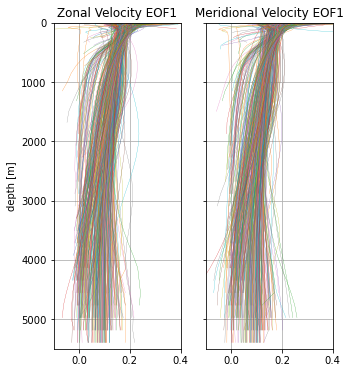

In [270]:
# sample non-rescaled 
f, (ax1,ax2) = plt.subplots(1,2,figsize=(5,6))
for i in range(0,50,2):
    for j in range(0,50,2):
        ax1.plot(eof1u_t[:,i,j],EOF_z,linewidth=0.25)
        ax2.plot(eof1v_t[:,i,j],EOF_z,linewidth=0.25)
ax1.set_ylim([0,5500]); ax1.invert_yaxis(); ax1.grid(); ax1.set_xlim([-0.1,0.4])
ax2.set_ylim([0,5500]); ax2.invert_yaxis(); ax2.grid(); ax2.set_xlim([-0.1,0.4]); ax2.set_yticklabels('')
ax1.set_title('Zonal Velocity EOF1')
ax2.set_title('Meridional Velocity EOF1')
ax1.set_ylabel('depth [m]')
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/sample_eofs.jpg', dpi=300)

In [8]:
# OPTION 2
# rescale in depth so surface is zero and bottom is one 
rs_grid = np.arange(0,1,0.02)
rs_train_u = np.nan*np.ones((len(rs_grid), np.shape(X_train0)[1]))
rs_train_v = np.nan*np.ones((len(rs_grid), np.shape(X_train0)[1]))
for i in tqdm(range(np.shape(X_train0)[1])): #range(916,917): # 
    this_p_u = X_train0[:,i] 
    this_p_v = X_train1[:,i]
    if np.sum(np.isnan(this_p_u)) > (len(this_p_u) - 5):
        continue
    g = np.where(~np.isnan(this_p_u))[0]
    max_dep = np.nanmax(EOF_z[g])
    if (len(g) > 10) & (np.nanmax(EOF_z[g]) > 1000):
        rs_train_u[:,i] = np.interp(rs_grid,EOF_z[g]/max_dep,this_p_u[g])
        rs_train_v[:,i] = np.interp(rs_grid,EOF_z[g]/max_dep,this_p_v[g])
good = np.where(~np.isnan(rs_train_u[10,:]))[0]
rs_train_u = rs_train_u[:,good]
rs_train_v = rs_train_v[:,good]
X_trainU = rs_train_u
X_trainV = rs_train_v

100%|██████████| 86400/86400 [00:02<00:00, 38313.29it/s]


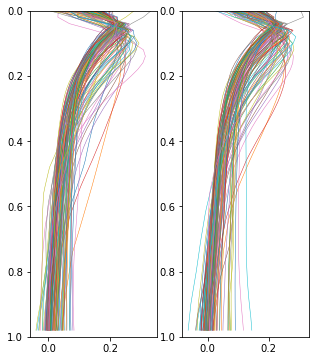

In [9]:
# sample set of rescaled profiles (OPTION 2)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(5,6))
for i in range(100):
    ax1.plot(rs_train_u[:,i],rs_grid,linewidth=0.5)
    ax2.plot(rs_train_v[:,i],rs_grid,linewidth=0.5)
ax1.set_ylim([0,1]); ax1.invert_yaxis()
ax2.set_ylim([0,1]); ax2.invert_yaxis()

In [10]:
# -- create lat/lon grid to subsample and re-shape
# -- for either re-scaled or not -- 
Lon,Lat = np.meshgrid(lon1,lat1)
Lon_t = Lon[lat_band,:]
Lat_t = Lat[lat_band,:]
LonR = np.reshape(Lon_t,(np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))
LatR = np.reshape(Lat_t,(np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))
lon_train = LonR[good]
lon_train = lon_train # [0::deci]
lat_train = LatR[good]
lat_train = lat_train # [0::deci]

In [11]:
# PCA (U)
pca = decomposition.PCA(n_components=6) 
# fit the PCA to the training data 
pca.fit(np.transpose(X_trainU))
# transform the training data to reduced PCA/EOF space
X_pca_train = pca.transform(np.transpose(X_trainU))
# X_pca_inv = pca.inverse_transform(np.transpose(X_train1))
# get the variance explained by each principal component
variance_sum = np.cumsum(pca.explained_variance_ratio_)

# PCA (V)
pcaV = decomposition.PCA(n_components=6) 
# fit the PCA to the training data 
pcaV.fit(np.transpose(X_trainV))
# transform the training data to reduced PCA/EOF space
X_pca_trainV = pcaV.transform(np.transpose(X_trainV))
# X_pca_inv = pca.inverse_transform(np.transpose(X_train1))
# get the variance explained by each principal component
variance_sumV = np.cumsum(pcaV.explained_variance_ratio_)

In [155]:
n_clusters = 6
gmmU = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X_pca_train)
gmmV = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X_pca_trainV)
labelsU = gmmU.predict(X_pca_train)
labelsV = gmmV.predict(X_pca_trainV)

In [156]:
cluster_mapU = np.nan*np.ones((len(lat1),len(lon1)))
cluster_mapV = np.nan*np.ones((len(lat1),len(lon1)))
for i in range(len(labelsU)):
    this_lon = lon_train[i]
    this_lat = lat_train[i]
    loc_lon = np.where(lon1 == this_lon)[0]
    loc_lat = np.where(lat1 == this_lat)[0]
    cluster_mapU[loc_lat,loc_lon] = labelsU[i]
    cluster_mapV[loc_lat,loc_lon] = labelsV[i]

In [179]:
plt.get_cmap('viridis',n_clusters)

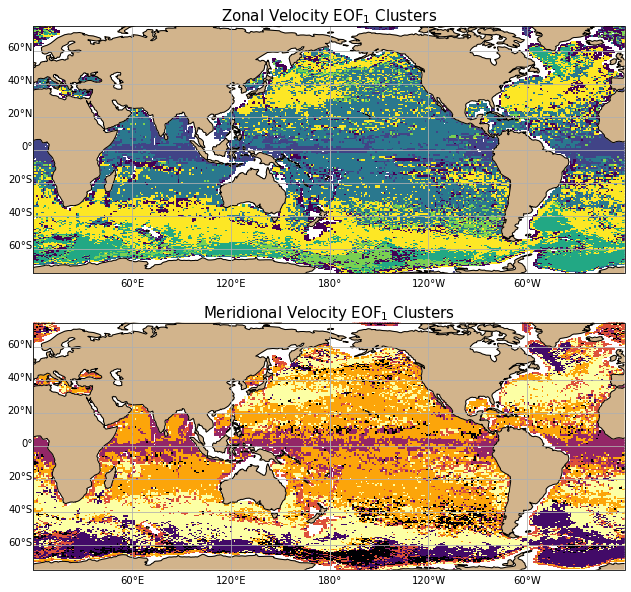

In [191]:
colors1 = plt.get_cmap('viridis',n_clusters)
# colors1 = []
# for i in range(n_clusters):
#     colors1.append(cmo.cm.phase(i/n_clusters))
# colors1 = cmo.cm.thermal
colors2 = plt.get_cmap('inferno',n_clusters)

f, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax1.pcolor(lon1,lat1,cluster_mapU, transform=ccrs.PlateCarree(), cmap=colors1, vmin=0, vmax=n_clusters) 
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax1.coastlines(); gl = ax1.gridlines(draw_labels=True); ax1.set_title(r'Zonal Velocity EOF$_1$ Clusters',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax1.set_ylim([-75,75])

ax2.pcolor(lon1,lat1,cluster_mapV, transform=ccrs.PlateCarree(), cmap=colors2, vmin=0, vmax=n_clusters) 
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines(); gl = ax2.gridlines(draw_labels=True); ax2.set_title(r'Meridional Velocity EOF$_1$ Clusters',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax2.set_ylim([-75,75])
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6.jpg', dpi=300)

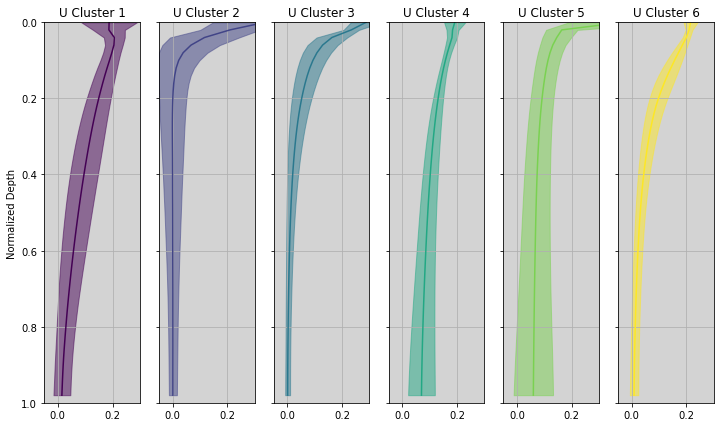

In [192]:
f, ax = plt.subplots(1,n_clusters,figsize=(12,7),sharey=True)
for i in range(n_clusters):
    li = X_trainU[:,labelsU==i]
    ax[i].plot(np.nanmean(li,axis=1),rs_grid, color=colors1(i))
    ax[i].fill_betweenx(rs_grid,np.nanmean(li,axis=1)-np.nanstd(li,axis=1),\
                        x2=np.nanmean(li,axis=1)+np.nanstd(li,axis=1), color=colors1(i), alpha=0.5)
    ax[i].set_xlim([-0.05,0.3]); ax[i].set_ylim([0,1]); ax[i].grid()
    ax[i].set_title('U Cluster ' + str(i+1))
    ax[i].set_facecolor('#D3D3D3')
ax[0].invert_yaxis(); ax[0].set_ylabel('Normalized Depth')
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_U_profiles.jpg', dpi=300)

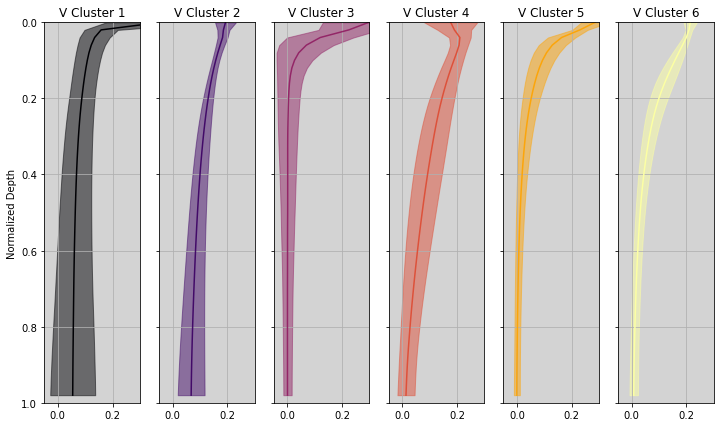

In [194]:
f, ax = plt.subplots(1,n_clusters,figsize=(12,7),sharey=True)
for i in range(n_clusters):
    li = X_trainV[:,labelsV==i]
    ax[i].plot(np.nanmean(li,axis=1),rs_grid, color=colors2(i))
    ax[i].fill_betweenx(rs_grid,np.nanmean(li,axis=1)-np.nanstd(li,axis=1),\
                        x2=np.nanmean(li,axis=1)+np.nanstd(li,axis=1), color=colors2(i), alpha=0.5)
    ax[i].set_xlim([-0.05,0.3]); ax[i].set_ylim([0,1]); ax[i].grid()
    ax[i].set_facecolor('#D3D3D3')
    ax[i].set_title('V Cluster ' + str(i+1))
ax[0].invert_yaxis(); ax[0].set_ylabel('Normalized Depth')
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_V_profiles.jpg', dpi=300)

In [237]:
# DISTRIBUTION OF ROUGHNESS/rho DECAY/MKE WITHIN CLUSTERS 
rough_in = []; decay_in = []; mke_in = []; eke_in = []; pvar_in = []
for i in range(n_clusters):
    cluster_loc_i = np.where(cluster_mapV == i)
    rough_in_i = []
    decay_in_i = []
    mke_in_i = []
    eke_in_i = []
    pvar_in_i = []
    for j in tqdm(range(len(cluster_loc_i[0]))):
        this_lon = Lon[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        this_lat = Lat[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        r_lon_in = np.where((lon > (this_lon - 0.2)) & (lon < (this_lon + 0.2)))
        r_lat_in = np.where((lat > (this_lat - 0.2)) & (lat < (this_lat + 0.2)))
        rough_in_i.append(np.nanmean(roughness[r_lat_in][:,r_lon_in]))
        d_lon_in = np.where((lon_d > (this_lon - 0.5)) & (lon_d < (this_lon + 0.5)))
        d_lat_in = np.where((lat_d > (this_lat - 0.5)) & (lat_d < (this_lat + 0.5)))
        decay_in_i.append(np.nanmean(decay[d_lat_in][:,d_lon_in]))
        m_lon_in = np.where((lonBT[::2] > (this_lon - 0.25)) & (lonBT[::2] < (this_lon + 0.25)))
        m_lat_in = np.where((latBT[::2] > (this_lat - 0.25)) & (latBT[::2] < (this_lat + 0.25)))
        mke_in_i.append(np.nanmean(MKE.data[m_lat_in][:,m_lon_in]))
        e_lon_in = np.where((lonUV[::2] > (this_lon - 0.5)) & (lonUV[::2] < (this_lon + 0.5)))
        e_lat_in = np.where((latUV[::2] > (this_lat - 0.5)) & (latUV[::2] < (this_lat + 0.5)))
        eke_in_i.append(np.nanmean(EKE.data[e_lat_in][:,e_lon_in]))
        p_lon_in = np.where((lon1 > (this_lon - 0.25)) & (lon1 < (this_lon + 0.25)))
        p_lat_in = np.where((lat1 > (this_lat - 0.25)) & (lat1 < (this_lat + 0.25)))
        pvar_in_i.append(np.nanmean(cmEOF.pvarv.data[p_lat_in][:,p_lon_in]))
    rough_in.append(rough_in_i)
    decay_in.append(decay_in_i)
    mke_in.append(mke_in_i)
    eke_in.append(mke_in_i)
    pvar_in.append(pvar_in_i)

100%|██████████| 13360/13360 [00:09<00:00, 1463.47it/s]


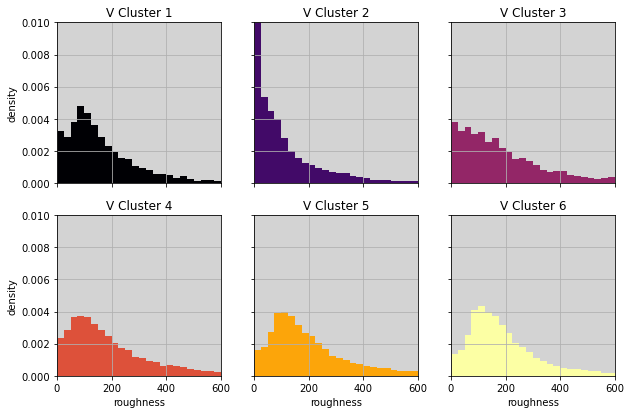

In [203]:
# ROUGHNESS 
f, ax = plt.subplots(2,3,figsize=(10,6.5)); gax = ax.flatten()
for i in range(n_clusters):
    nn = gax[i].hist(rough_in[i],bins=np.arange(0,1000,25),color=colors2(i),density=True)
    gax[i].set_ylim([0,0.01])
    # gax[i].set_yscale('log')
    # gax[i].set_ylim([0,0.0125]); 
    gax[i].set_xlim([0,600])
    if (i == 1) | (i == 2) | (i == 4) | (i == 5):
        gax[i].set_yticklabels('')
    if (i == 0) | (i == 3):
        gax[i].set_ylabel('density')
    if i > 2:
        gax[i].set_xlabel('roughness')
    if i < 3:
        gax[i].set_xticklabels('')
    gax[i].set_title('V Cluster ' + str(i+1))
    gax[i].set_facecolor('#D3D3D3')
    gax[i].grid()
gax[0].set_title('V Cluster ' + str(0+1))
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_roughness_dist.jpg', dpi=300)

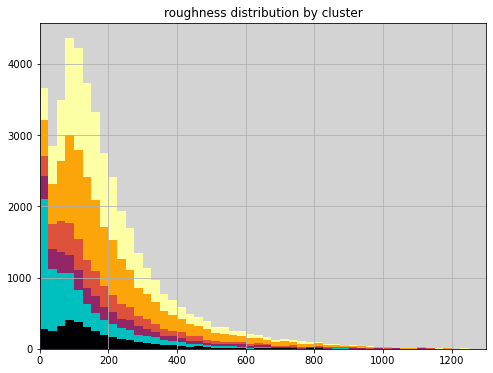

In [208]:
f, ax = plt.subplots(1,1,figsize=(8,6))
previous = 0
for i in range(n_clusters):
    if i == 1:
        nn = ax.hist(rough_in[i],bins=np.arange(0,1300,25),color='c',density=False,bottom=previous)
        previous = nn[0] + previous
    else:
        nn = ax.hist(rough_in[i],bins=np.arange(0,1300,25),color=colors2(i),density=False,bottom=previous)
        previous = nn[0] + previous
ax.set_xlim([0,1300])
ax.set_facecolor('#D3D3D3')
ax.set_title('roughness distribution by cluster')
ax.grid()
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_roughness_cum_dist_2.jpg', dpi=300)

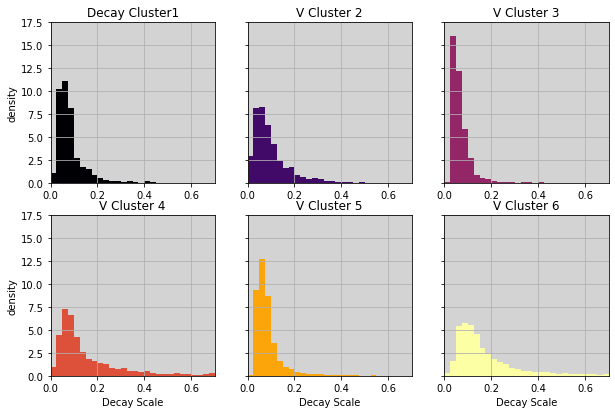

In [214]:
# DENSITY DECAY 
f, ax = plt.subplots(2,3,figsize=(10,6.5)); gax = ax.flatten()
for i in range(n_clusters):
    nn = gax[i].hist(decay_in[i],bins=np.arange(0,1,0.025),color=colors2(i),density=True)
    # gax[i].set_ylim([10,1000])
    # gax[i].set_scale('log')
    gax[i].set_ylim([0,17.5]); 
    gax[i].set_xlim([0,0.7])
    if (i == 1) | (i == 2) | (i == 4) | (i == 5):
        gax[i].set_yticklabels('')
    if (i == 0) | (i == 3):
        gax[i].set_ylabel('density')
    if i > 2:
        gax[i].set_xlabel('Decay Scale')
    gax[i].set_title('V Cluster ' + str(i+1))
    gax[i].set_facecolor('#D3D3D3')
    gax[i].grid()
gax[0].set_title('Decay Cluster' + str(0+1))
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_decay_dist.jpg', dpi=300)

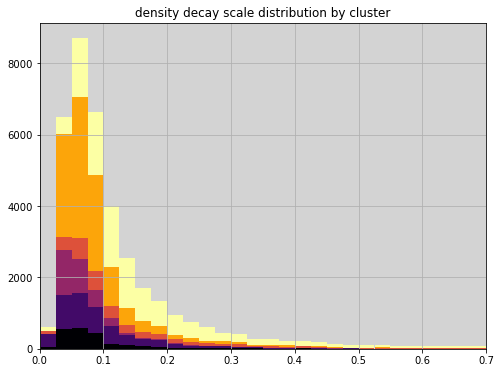

In [217]:
f, ax = plt.subplots(1,1,figsize=(8,6))
previous = 0
for i in range(n_clusters):
    nn = ax.hist(decay_in[i],bins=np.arange(0,1,0.025),color=colors2(i),density=False,bottom=previous)
    previous = nn[0] + previous
ax.set_xlim([0,0.7])
ax.set_title('density decay scale distribution by cluster')
ax.set_facecolor('#D3D3D3')
ax.grid()
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_decay_cum_dist.jpg', dpi=300)

Text(0.5, 1.0, 'EKE Cluster1')

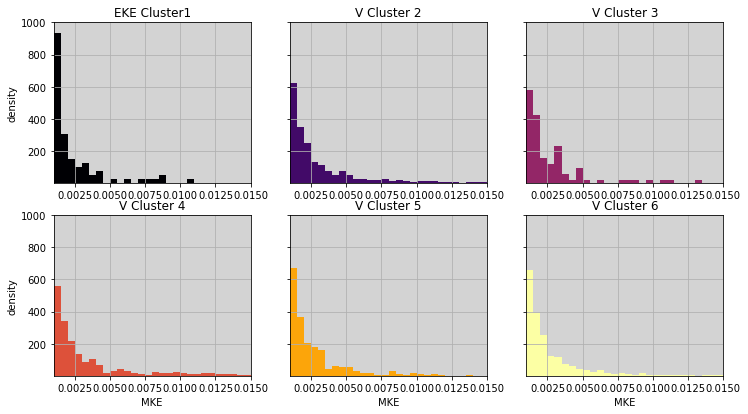

In [248]:
# EKE 
f, ax = plt.subplots(2,3,figsize=(12,6.5)); gax = ax.flatten()
for i in range(n_clusters):
    nn = gax[i].hist(eke_in[i],bins=np.arange(0.001,0.03,0.0005),color=colors2(i),density=True)
    # print(np.nanmean(eke_in[i]))
    # gax[i].set_ylim([10,1000])
    gax[i].set_ylim([1,1000]); 
    gax[i].set_xlim([0.001,0.015])
    # gax[i].set_xscale('log')
    # gax[i].set_yscale('log')
    if (i == 1) | (i == 2) | (i == 4) | (i == 5):
        gax[i].set_yticklabels('')
    if (i == 0) | (i == 3):
        gax[i].set_ylabel('density')
    if i > 2:
        gax[i].set_xlabel('MKE')
    gax[i].set_title('V Cluster ' + str(i+1))
    gax[i].set_facecolor('#D3D3D3')
    gax[i].grid()
gax[0].set_title('EKE Cluster' + str(0+1))
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_mke_dist.jpg', dpi=300)

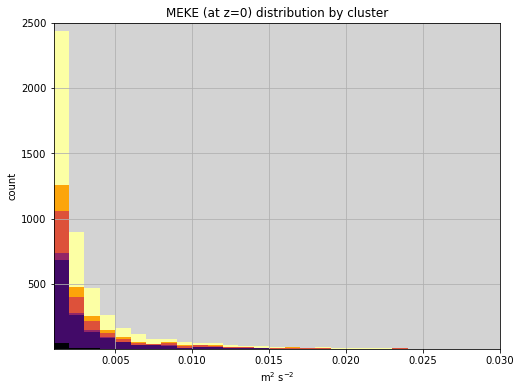

In [273]:
f, ax = plt.subplots(1,1,figsize=(8,6))
previous = 0
for i in range(n_clusters):
    nn = ax.hist(eke_in[i],bins=np.arange(0.001,0.03,0.001),color=colors2(i),density=False,bottom=previous)
    previous = nn[0] + previous
ax.set_xlim([0.001,0.03])
ax.set_ylim([0.9,2500])
# ax.set_yscale('log')
ax.set_ylabel('count')
ax.set_xlabel(r'm$^2$ s$^{-2}$')
ax.set_facecolor('#D3D3D3')
ax.set_title('MEKE (at z=0) distribution by cluster')
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_eke_dist_nonlog.jpg', dpi=300)

Text(0.5, 1.0, 'pvarV Cluster1')

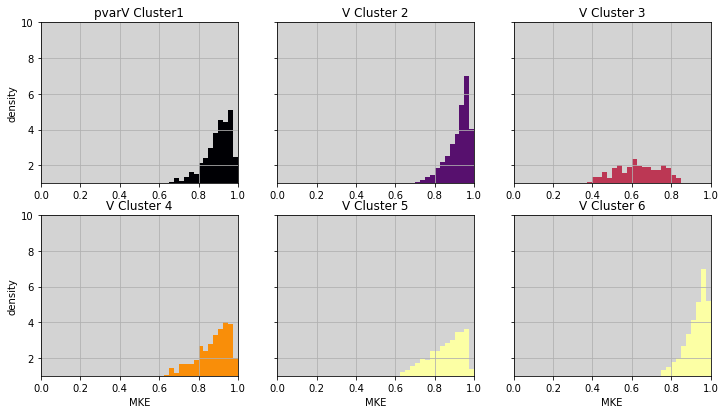

In [158]:
# PVAR 
f, ax = plt.subplots(2,3,figsize=(12,6.5)); gax = ax.flatten()
for i in range(n_clusters):
    nn = gax[i].hist(pvar_in[i],bins=np.arange(0,1.025,0.025),color=colors2(i),density=True)
    # gax[i].set_ylim([10,1000])
    gax[i].set_ylim([1,10]); 
    gax[i].set_xlim([0,1])
    if (i == 1) | (i == 2) | (i == 4) | (i == 5):
        gax[i].set_yticklabels('')
    if (i == 0) | (i == 3):
        gax[i].set_ylabel('density')
    if i > 2:
        gax[i].set_xlabel('MKE')
    gax[i].set_title('V Cluster ' + str(i+1))
    gax[i].set_facecolor('#D3D3D3')
    gax[i].grid()
gax[0].set_title('pvarV Cluster' + str(0+1))
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_mke_dist.jpg', dpi=300)

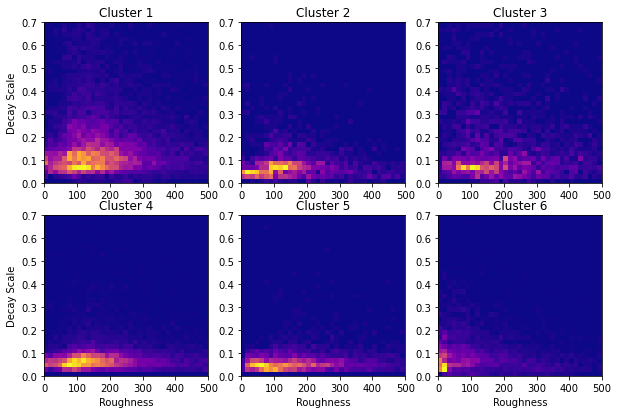

In [191]:
f, ax = plt.subplots(2,3,figsize=(10,6.5)); gax = ax.flatten()
for i in range(n_clusters):
    gax[i].hist2d(rough_in[i],decay_in[i],bins=[35,35],range=[[0, 500],[0,0.7]],\
              density=True,cmin=0,cmax=1,cmap=plt.get_cmap('plasma'));
    if i > 2:
        gax[i].set_xlabel('Roughness')
    if (i == 0) | (i == 3):
        gax[i].set_ylabel('Decay Scale')
    gax[i].set_title('Cluster ' + str(i+1))
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/clusters6_rough_decay.jpg', dpi=300)

In [130]:
# N2 DECAY 
fitd0 = -20; fitd1 = -550;
# fit_ind = np.where((-1*N2_s_z < fitd0) & (-1*N2_s_z > fitd1))[0]
# N2_z = -1*N2_s_z[fit_ind]
fit_ind = np.where((N2_z < fitd0) & (N2_z > fitd1))[0]
decay = np.nan * np.ones((np.shape(N2)[0], np.shape(N2)[1]))
misfit = np.nan * np.ones(np.shape(decay))
for i in tqdm(range(np.shape(N2)[0])):
    for j in range(np.shape(N2)[1]):
        this_N2 = np.squeeze(N2[i,j,fit_ind])
        if np.sum(np.isnan(this_N2[0:5])) == 5:
            continue
        nancheck = np.where(this_N2 <= 0)[0]
        if len(nancheck) > 0: 
            upper_ocean_pos = np.where(this_N2[0:5] > 0)
            this_N2[nancheck] = np.nanmean(this_N2[upper_ocean_pos])
        p = np.polyfit(N2_z[fit_ind], np.log(this_N2), 1)
        decay[i,j] = 1/p[0]

100%|██████████| 360/360 [00:03<00:00, 102.87it/s]


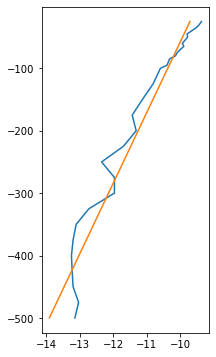

In [133]:
f, ax = plt.subplots(1,1,figsize=(3,6))
ax.plot(np.log(this_N2),N2_z[fit_ind])
ax.plot(np.polyval(p,N2_z[fit_ind]),N2_z[fit_ind])

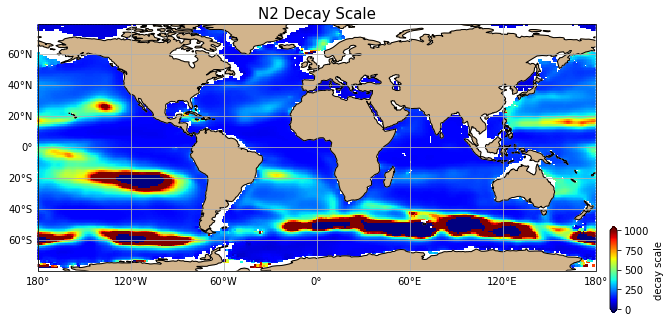

In [143]:
f, ax1 = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc = ax1.pcolor(lon1,N2_lat,np.transpose(decay),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'), vmin=0, vmax=1000) 
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax1.coastlines(); gl = ax1.gridlines(draw_labels=True); ax1.set_title('N2 Decay Scale',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
cbpos = [0.92, 0.12, 0.01, 0.2]; cax = f.add_axes(cbpos);
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='decay scale')